In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data.csv
./Project_2.ipynb
./raw_data.csv
./.ipynb_checkpoints/data-checkpoint.csv
./.ipynb_checkpoints/Project_2-checkpoint.ipynb
./.ipynb_checkpoints/raw_data-checkpoint.csv
./ScrapingChicago/raw_data_sold.csv
./ScrapingChicago/package.log
./ScrapingChicago/HomeHarvest_20250910_003045.csv
./ScrapingChicago/.gitignore
./ScrapingChicago/data.csv
./ScrapingChicago/raw_data.csv
./ScrapingChicago/scraper.ipynb
./ScrapingChicago/.ipynb_checkpoints/data-checkpoint.csv
./ScrapingChicago/.ipynb_checkpoints/scraper-checkpoint.ipynb
./ScrapingChicago/.ipynb_checkpoints/HomeHarvest_20250910_003045-checkpoint.csv
./ScrapingChicago/.ipynb_checkpoints/raw_data-checkpoint.csv
./ScrapingChicago/.ipynb_checkpoints/raw_data_sold-checkpoint.csv
./ScrapingChicago/.ipynb_checkpoints/df-checkpoint.csv


# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Market prices are an important thing to consider when buying a house. This ML project aims to predict the price a house will be sold at given certain attributes. We must use data from public real estate websites and then build a property selling price predictor for a city, which is, in my case, Chicago. 

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

I used the Python Library HomeHarvest, which scrapes data from Realtors.com, Zillow, and Redfin. I used it to scrap for any homes sold, pending, or for sale in Chicago. Then, I saved the data as a csv. 

In [2]:
from homeharvest import scrape_property
from datetime import datetime

In [3]:
current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"HomeHarvest_{current_timestamp}.csv"

sold_properties = scrape_property(
    location="Chicago, IL",
    listing_type="sold",
    past_days=730,
)
print(f"Number of sold properties: {len(sold_properties)}")
print(sold_properties.head())

Number of sold properties: 10000
                                        property_url property_id  listing_id  \
0  https://www.realtor.com/realestateandhomes-det...  8818482037  2984273843   
1  https://www.realtor.com/realestateandhomes-det...  8216192504  2984576190   
2  https://www.realtor.com/realestateandhomes-det...  8594991179  2985122320   
3  https://www.realtor.com/realestateandhomes-det...  9705735225  2985525785   
4  https://www.realtor.com/realestateandhomes-det...  8018556780  2985200594   

                                           permalink   mls    mls_id status  \
0  100-E-Bellevue-Pl-Apt-5F_Chicago_IL_60611_M881...  CHIL  12419255   SOLD   
1   4124-N-Pontiac-Ave_Chicago_IL_60634_M82161-92504  CHIL  12425181   SOLD   
2   7951-S-Prairie-Ave_Chicago_IL_60619_M85949-91179  CHIL  12440656   SOLD   
3  211-N-Harbor-Dr-Apt-1304_Chicago_IL_60601_M970...  CHIL  12443988   SOLD   
4     11656-S-Avenue-N_Chicago_IL_60617_M80185-56780  CHIL  12442316   SOLD   

  mls_statu

In [4]:
pending_properties = scrape_property(
    location="Chicago, IL",
    listing_type="pending",
    past_days=730,
)
print(f"Number of pending properties: {len(pending_properties)}")
print(pending_properties.head())

Number of pending properties: 3449
                                        property_url property_id  listing_id  \
0  https://www.realtor.com/realestateandhomes-det...  9201200075  2985818567   
1  https://www.realtor.com/realestateandhomes-det...  8905842516  2985682212   
2  https://www.realtor.com/realestateandhomes-det...  7601840697  2986363629   
3  https://www.realtor.com/realestateandhomes-det...  7805713039  2985582013   
4  https://www.realtor.com/realestateandhomes-det...  8439246654  2986046829   

                                           permalink   mls    mls_id  \
0  1335-N-Astor-St-Apt-12A_Chicago_IL_60610_M9201...  CHIL  12275529   
1  1416-W-Olive-Ave-Apt-2_Chicago_IL_60660_M89058...  CHIL  12454133   
2   5844-N-Navarre-Ave_Chicago_IL_60631_M76018-40697  CHIL  12469656   
3  3736-W-61st-Pl-Apt-3_Chicago_IL_60629_M78057-1...  CHIL  12452635   
4        549-E-91st-St_Chicago_IL_60619_M84392-46654  STNY  11568684   

       status mls_status                           

In [348]:
for_sale_properties = scrape_property(
    location="Chicago, IL",
    listing_type="for_sale",
    past_days=730,
)
print(f"Number of for sale properties: {len(for_sale_properties)}")
print(for_sale_properties.head())

Number of for sale properties: 9639
                                        property_url property_id  listing_id  \
0  https://www.realtor.com/realestateandhomes-det...  8942673680  2983159744   
1  https://www.realtor.com/realestateandhomes-det...  7865575441  2985016398   
2  https://www.realtor.com/realestateandhomes-det...  7818480920  2986269024   
3  https://www.realtor.com/realestateandhomes-det...  7731920998  2985232795   
4  https://www.realtor.com/realestateandhomes-det...  8011550783  2986240347   

                                           permalink   mls    mls_id  \
0  2946-N-Pine-Grove-Ave-Apt-1_Chicago_IL_60657_M...  CHIL  12393752   
1    1222-S-Karlov-Ave_Chicago_IL_60623_M78655-75441  CHIL  12437984   
2  6919-N-Overhill-Ave_Chicago_IL_60631_M78184-80920  CHIL  12469233   
3  1500-W-Monroe-St-Unit-523_Chicago_IL_60607_M77...  CHIL  12442545   
4     10843-S-Avenue-E_Chicago_IL_60617_M80115-50783  CHIL  12468607   

     status mls_status                            

In [459]:
import pandas as pd

In [484]:
df = pd.concat([sold_properties, pending_properties, for_sale_properties])
print(len(df))

23088


In [461]:
df.to_csv("raw_data.csv", index=False)

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

In [494]:
df = df[["property_id", "formatted_address", "zip_code", "style", "beds", 
                           "full_baths", "half_baths", "sqft", "year_built", 
                           "list_price", "sold_price", "latitude", "longitude", "stories"]]

df = df.dropna(subset=['zip_code', "list_price", "sold_price", "sqft", "beds", "full_baths"])
print(len(df))

df.drop_duplicates(inplace=True)
print(len(df))

8928
8928


In [495]:
df.to_csv("data.csv", index=False)

I've taken the dataset and some of the columns I've estimated will have the greatest value in this predictor. After dropping the nan values within a few important columns, my dataset is down to 10,383. After dropping all the duplicate values, I'm down to 8779 properties. This is a signifcant decrease from my original count of 22,719. 

A few of the columns I got are less important and will NOT be used for training, just identification purposes, like formatting address and property id. Zip code and style will need to be one-hot-encoded since they are categorical variables, and I'll combined full and half baths into a single baths column. 

In [496]:
import matplotlib.pyplot as plt

In [497]:
df["age"] = datetime.now().year - df["year_built"]
df.drop(columns="year_built", inplace=True)

In [500]:
# look at diff between sold and list price
# predicting sold price

# outlier calcs
outlier_upper = df["sold_price"].mean() + (2 * df["sold_price"].std())
outlier_lower = df["sold_price"].mean() - (2 * df["sold_price"].std())
print(f"Outlier bounds: {outlier_lower} - {outlier_upper}")

outliers = df[(df["sold_price"] > outlier_upper) | (df["sold_price"] < outlier_lower)]
print("Outliers:", outliers[["formatted_address", "sold_price"]])

df = df[(df["sold_price"] <= outlier_upper) | (df["sold_price"] >= outlier_lower)]
print(df.info())

Outlier bounds: -1053278.5875500343 - 1960778.0306503926
Outliers:                                     formatted_address sold_price
86             579 W Hawthorne Pl, Chicago, IL, 60657    2721500
129              1431 N Mohawk St, Chicago, IL, 60610    2200000
192            2026 N Clifton Ave, Chicago, IL, 60614    4250000
197            2043 N Clifton Ave, Chicago, IL, 60614    5150000
284          1942 N Cleveland Ave, Chicago, IL, 60614    2590000
...                                               ...        ...
7120     403 N Wabash Ave Apt 12B, Chicago, IL, 60611    2776500
8192    401 N Wabash Ave Unit 33K, Chicago, IL, 60611    2236500
8247      159 E Walton Pl Apt 15A, Chicago, IL, 60611    2000000
8485    401 N Wabash Ave Unit 49G, Chicago, IL, 60611    2500000
8877  800 N Michigan Ave Apt 2502, Chicago, IL, 60611    2405000

[208 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 8928 entries, 0 to 9633
Data columns (total 14 columns):
 #   Column             Non

Calculating statistical outlier bounds gives us a sold price outlier of 0 - around 2 million. This is a very large range and is most likely due to Chicago's diverse housing market.

In [501]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8928 entries, 0 to 9633
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   property_id        8928 non-null   object 
 1   formatted_address  8928 non-null   object 
 2   zip_code           8928 non-null   object 
 3   style              8928 non-null   object 
 4   beds               8928 non-null   int64  
 5   full_baths         8928 non-null   int64  
 6   half_baths         8928 non-null   int64  
 7   sqft               8928 non-null   int64  
 8   list_price         8928 non-null   object 
 9   sold_price         8928 non-null   object 
 10  latitude           8928 non-null   float64
 11  longitude          8928 non-null   float64
 12  stories            8928 non-null   int64  
 13  age                8928 non-null   int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 1.0+ MB


In [502]:
# convert to numbers


cols = df.columns.difference(['formatted_address', 'style'])
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [503]:
# look at the correlation between variables
corr_matrix = df.corr(numeric_only=True)
corr_matrix["sold_price"].sort_values(ascending=False)

sold_price     1.000000
list_price     0.616981
sqft           0.449857
full_baths     0.362112
half_baths     0.282703
beds           0.192323
longitude      0.067213
property_id    0.059206
stories        0.042726
age           -0.050145
latitude      -0.061638
zip_code      -0.110921
Name: sold_price, dtype: float64

From this I can see that the things that effect the price the most are the size, number of rooms, and location. 

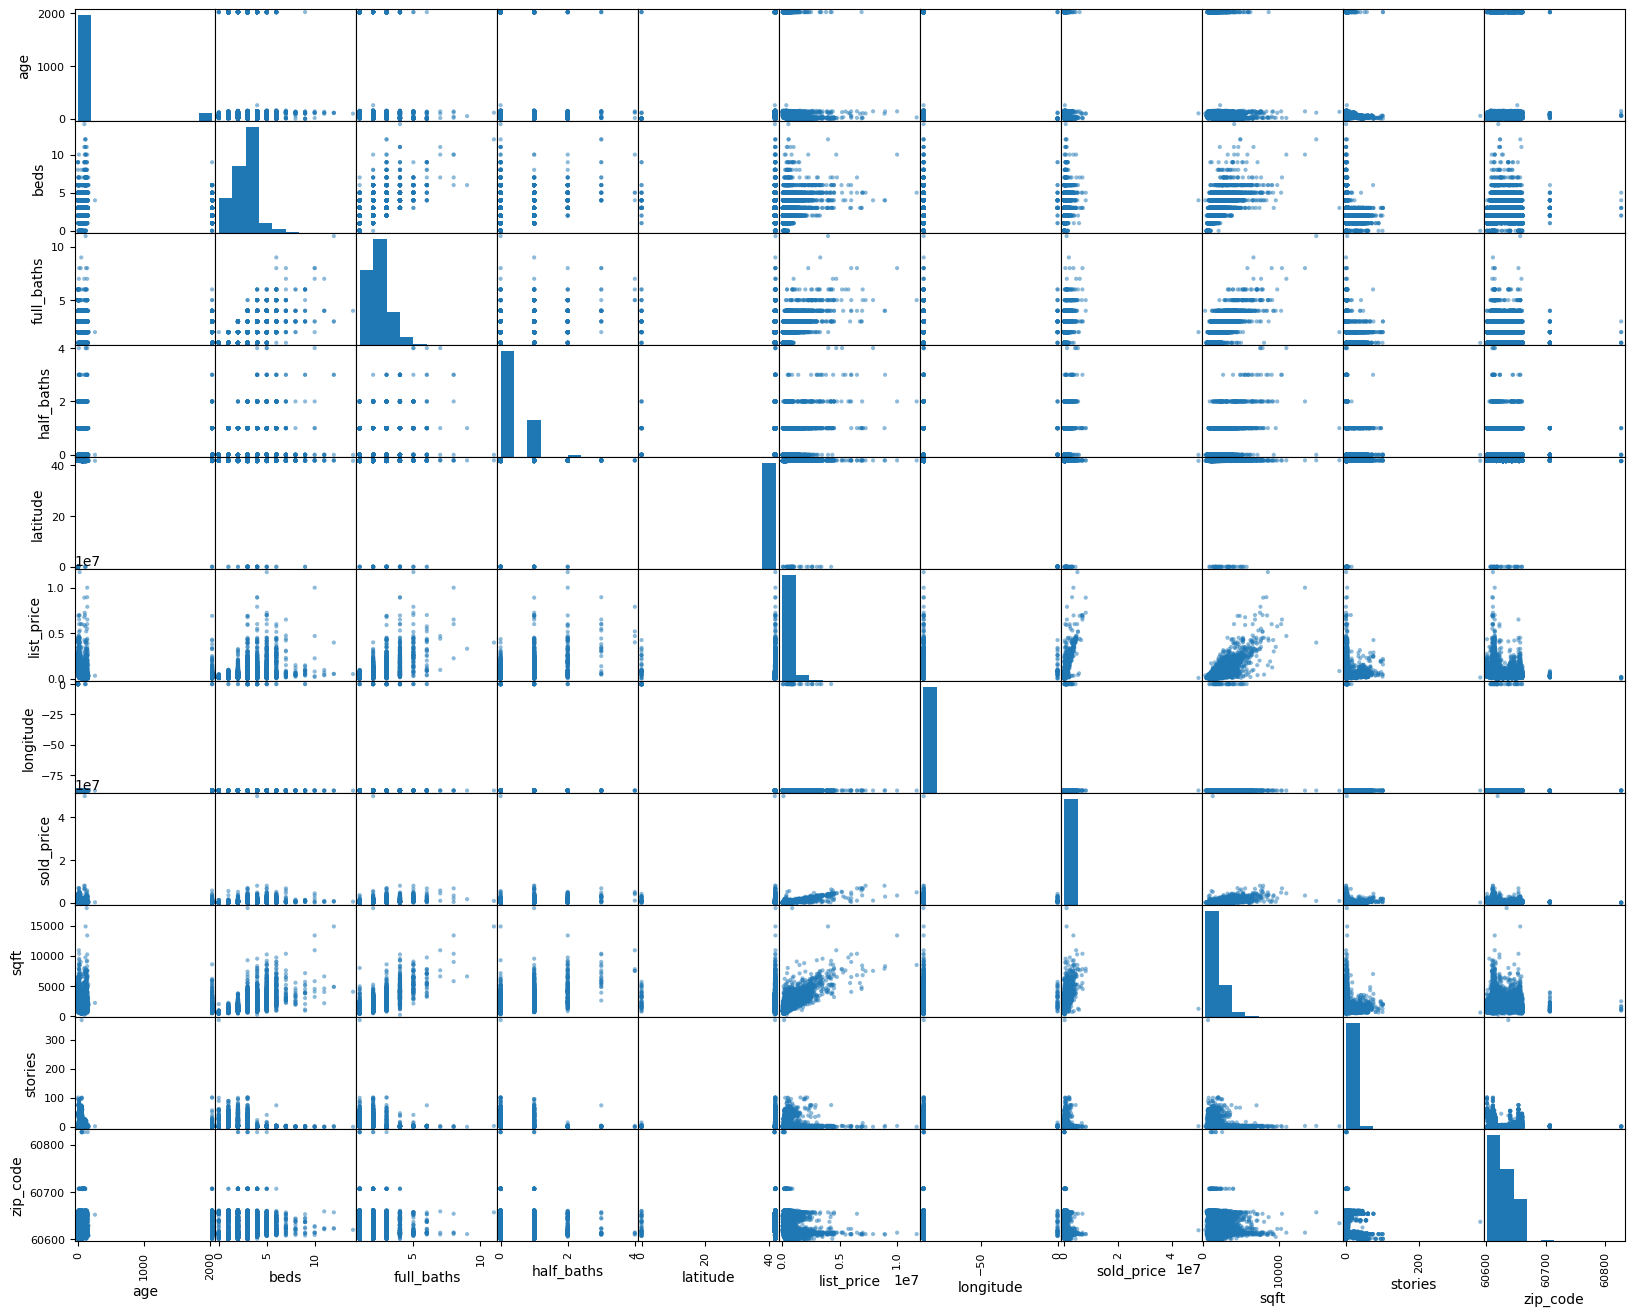

In [504]:
# scatter matrix

from pandas.plotting import scatter_matrix

attributes = df.columns.difference(['formatted_address', 'property_id', 'style'])
df["baths"] = df["full_baths"] + (df["half_baths"] * 0.5).bfill()
df["numOfRooms"] = df["baths"] + df["beds"]

scatter_matrix(df[attributes], figsize=(20,16))
plt.show()

There are not a lot of super obvious trends from just this scatter matrix, which suggests that Chicago has a really diverse market and it might be hard to predict prices even with geolocation.

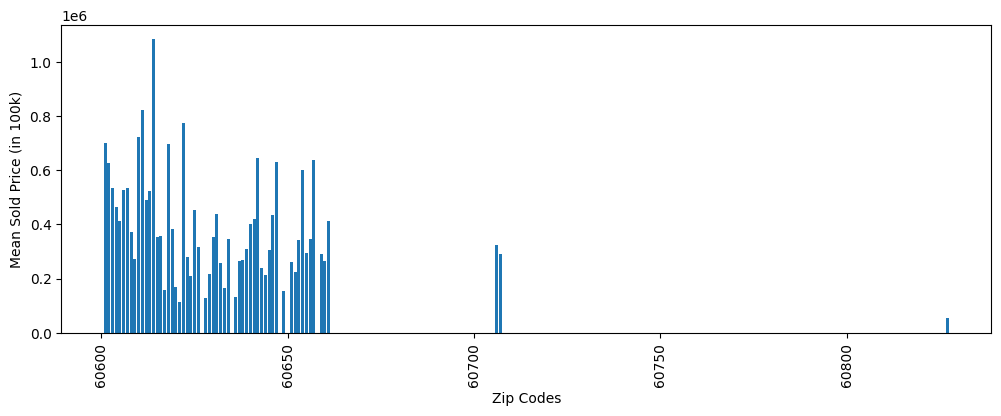

In [505]:
# zip_code vs. price
# would indicate richer zip codes

plt.figure(figsize=(12, 4))

grouped_data = df.groupby("zip_code", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["zip_code"], grouped_data["sold_price"])

plt.xticks(rotation=90)
plt.xlabel("Zip Codes")
plt.ylabel("Mean Sold Price (in 100k)")
plt.show()

The zipcodes need to be encoded.
The highest mean selling price has a zipcode of 60614, and the lowest is 60827. 

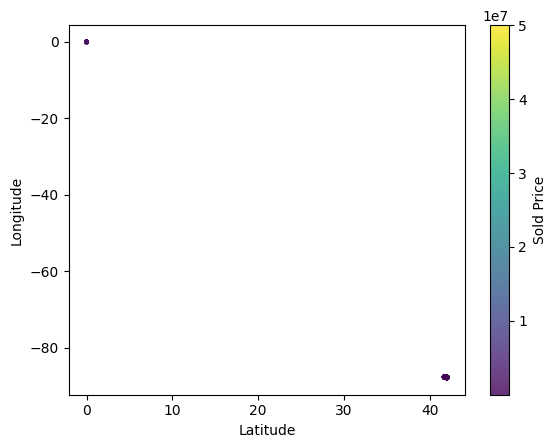

In [506]:
plt.scatter(df["latitude"], df["longitude"], c=df["sold_price"], cmap='viridis', s=5, alpha=0.8)
plt.colorbar(label='Sold Price')

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

This map traces out the shape of Chicago with all of the properties mapped using price as color. It's clear the majority of properties are just less or around 10^7 dollars. This may be a better alternative than using the zipcodes, although the numbers may vary a lot compared to using the zipcodes to "bin" the coordinates.

In [507]:
# lat and long for zip

lat_long_df = pd.read_csv("zipCodeToLatLong.csv")

df.rename(columns={"latitude": "zip_lat", "longitude": "zip_long"}, inplace=True)
df['zip_code'] = df['zip_code'].astype(int)
df = df.merge(lat_long_df, left_on="zip_code", right_on="zip", how="left")

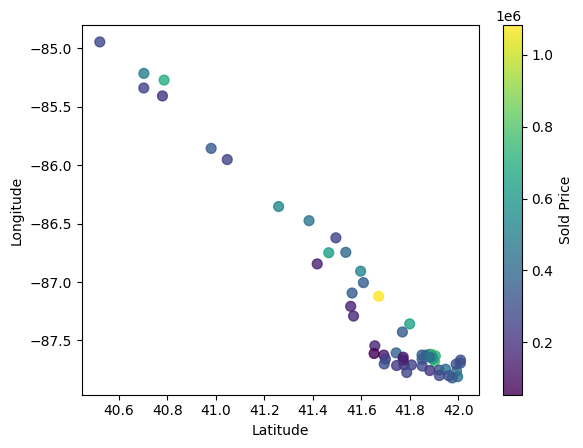

In [508]:
grouped_data = df.groupby("zip_code", as_index=False)[["sold_price", "zip_lat", "zip_long"]].mean()

plt.scatter(grouped_data["zip_lat"], grouped_data["zip_long"], c=grouped_data["sold_price"], cmap='viridis', s=50, alpha=0.8)
plt.colorbar(label='Sold Price')

plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

Grouping the data by zipcode gives us a clearer picture of where the richer areas of Chicago are (downtown). I still might use the raw latitudes and longitudes because they're more precise than this binning. 

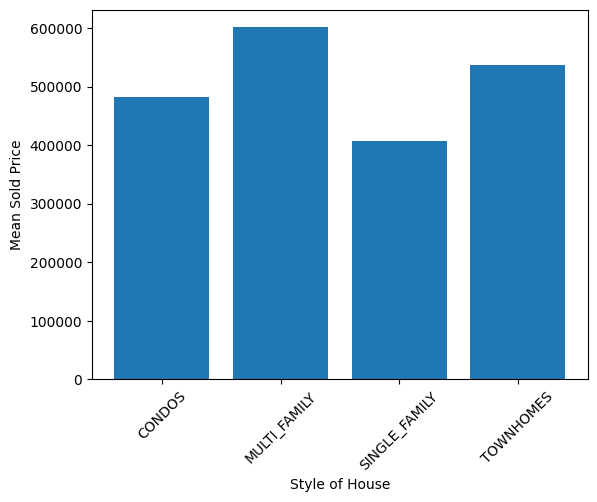

In [509]:
# style vs. price
# larger homes, pricier

grouped_data = df.groupby("style", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["style"], grouped_data["sold_price"])

plt.xticks(rotation=45)
plt.xlabel("Style of House")
plt.ylabel("Mean Sold Price")
plt.show()

The trends seem to make sense, with houses being higher than condos or single family houses. However, this metric might just be easier to figure out using the number of beds and baths.

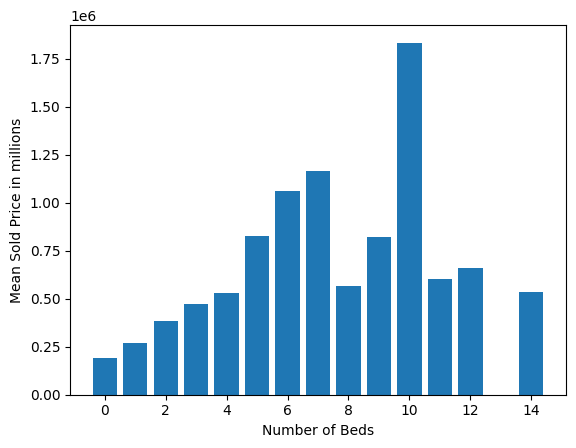

In [510]:
# beds vs. price
# more beds, higher price

grouped_data = df.groupby("beds", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["beds"], grouped_data["sold_price"])

plt.xlabel("Number of Beds")
plt.ylabel("Mean Sold Price in millions")
plt.show()

The sold price does increase and act as intended until about 7 rooms, and then it starts to go a little weird. 10 rooms has the maximum mean sold price, but 8, 11, and 14, which are all supposed to be high according to the trend, are very low, about the same price as the 5 room properties.

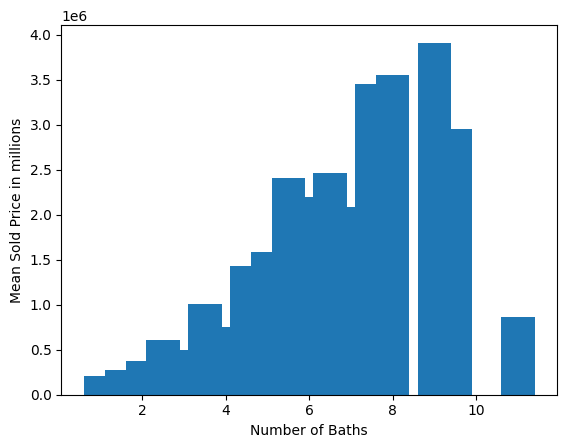

In [511]:
# baths vs. price
# more baths, higher price

grouped_data = df.groupby("baths", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["baths"], grouped_data["sold_price"])

plt.xlabel("Number of Baths")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This attribute does mostly follow the trend of increases rooms with increasing prices. It has a peak at around 8 baths. 

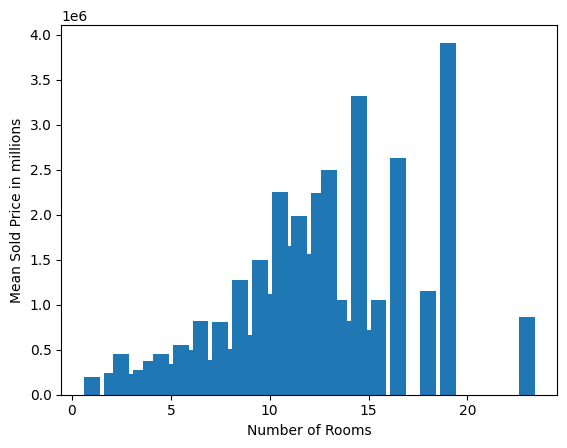

In [512]:
# combined bath + beds vs. sold price
# more rooms, higher price

df["numOfRooms"] = df["baths"] + df["beds"]

grouped_data = df.groupby("numOfRooms", as_index=False)["sold_price"].mean()

plt.bar(grouped_data["numOfRooms"], grouped_data["sold_price"])

plt.xlabel("Number of Rooms")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This seems to follow the trend, but there are some odd lower values at some points, like at 16 and 24 rooms. Not sure why the trend doesn't apply at this higher room counts.

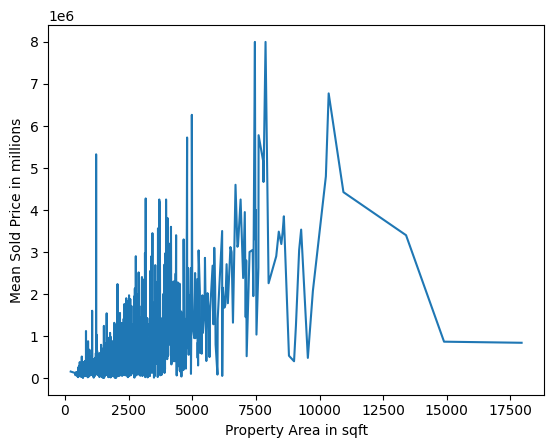

In [513]:
# sqft vs. sold price
# bigger house, higher price

grouped_data = df.groupby("sqft", as_index=False)["sold_price"].mean()

plt.plot(grouped_data["sqft"], grouped_data["sold_price"])

plt.xlabel("Property Area in sqft")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This attribute follows the trend as predicted. There are outliers for the properties with 15000 sqft which goes down, so it's a similar phenomenon as the bath and bed room issue of going down at extremely high values.

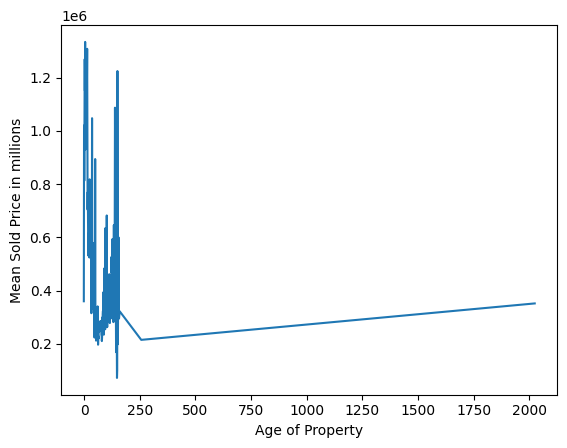

In [514]:
# age vs. sold price
# newer houses, higher price

grouped_data = df.groupby("age", as_index=False)["sold_price"].mean()

plt.plot(grouped_data["age"], grouped_data["sold_price"])

plt.xlabel("Age of Property")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This attribute has a lot of variation in the trend. The price is higher if the property is new, as expected, but it also seems to peak around 150 years in age, which might be able to be attributed to larger properties being older like historical buildings. 

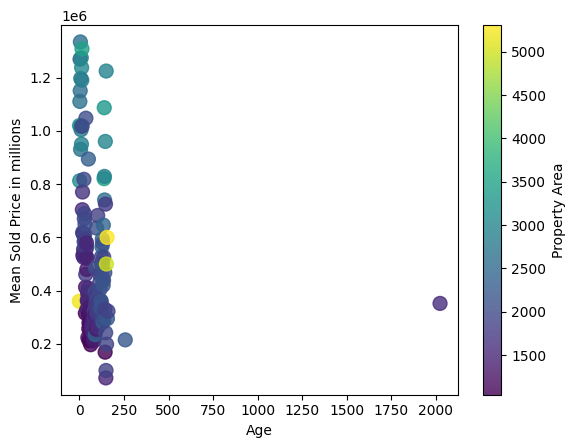

In [515]:
grouped_data = df.groupby("age", as_index=False)[["sold_price", "sqft"]].mean()

plt.scatter(grouped_data["age"], grouped_data["sold_price"], c=grouped_data["sqft"], cmap='viridis', s=100, alpha=0.8)
plt.colorbar(label='Property Area')

plt.xlabel("Age")
plt.ylabel("Mean Sold Price in millions")
plt.show()

This second graph actually doesn't follow the trend I expected it would. There is no discernable correlation between property area and the age. Some newer properties are very large, and so are some that are around 150 years old. There is a single outlier with an age of 250 years, a medium-size area, and a low price.

# 4.Prepare the Data


Apply any data transformations and explain what and why


After looking through the statistics, I've determined the features I'll be including to maximize prediction accuracy and minimize parameter count are number of rooms, property area, age, and geographic location. Although number of rooms and property area seem to follow very similar trends, so I might be able to not use that attribute.

In [520]:
df.columns = df.columns.str.strip()
df.head()

,property_id,formatted_address,zip_code,style,beds,full_baths,half_baths,sqft,list_price,sold_price,zip_lat,zip_long,stories,age,baths,numOfRooms,zip,latitude,longitude,home_style
0,8818482037,"100 E Bellevue Pl Apt 5F, Chicago, IL, 60611",60611,CONDOS,2,2,0,1400,600000,585000,41.901890,-87.625653,0,54,2.0,4.0,60611,41.894742,-87.615073,0.0
1,8216192504,"4124 N Pontiac Ave, Chicago, IL, 60634",60634,SINGLE_FAMILY,3,2,0,1766,365000,345000,41.954683,-87.835812,2,77,2.0,5.0,60634,41.946189,-87.806117,1.0
2,9705735225,"211 N Harbor Dr Apt 1304, Chicago, IL, 60601",60601,CONDOS,2,2,0,1251,990000,995000,41.886326,-87.614693,0,3,2.0,4.0,60601,41.885155,-87.621512,0.0
3,8018556780,"11656 S Avenue N, Chicago, IL, 60617",60617,SINGLE_FAMILY,4,2,0,1788,429000,420000,41.682921,-87.539210,0,28,2.0,6.0,60617,41.714417,-87.555761,1.0
4,8509659172,"155 N Harbor Dr Apt 1111, Chicago, IL, 60601",60601,CONDOS,2,2,0,1369,480000,460000,41.885700,-87.615700,0,51,2.0,4.0,60601,41.885155,-87.621512,0.0


In [530]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories=[['CONDOS', 'SINGLE_FAMILY', 'TOWNHOMES', 'MULTI_FAMILY']])
df['home_style'] = encoder.fit_transform(df[['style']])

In [531]:
# i've already dropped the nans
print(df.info())

model_df = df[["sold_price", "numOfRooms", "sqft", "age", "home_style", "latitude", "longitude", "stories"]].convert_dtypes().fillna(0)
model_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8928 entries, 0 to 8927
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   property_id        8928 non-null   int64  
 1   formatted_address  8928 non-null   object 
 2   zip_code           8928 non-null   int64  
 3   style              8928 non-null   object 
 4   beds               8928 non-null   int64  
 5   full_baths         8928 non-null   int64  
 6   half_baths         8928 non-null   int64  
 7   sqft               8928 non-null   int64  
 8   list_price         8928 non-null   int64  
 9   sold_price         8928 non-null   int64  
 10  zip_lat            8928 non-null   float64
 11  zip_long           8928 non-null   float64
 12  stories            8928 non-null   int64  
 13  age                8928 non-null   int64  
 14  baths              8928 non-null   float64
 15  numOfRooms         8928 non-null   float64
 16  zip                8928 

,sold_price,numOfRooms,sqft,age,home_style,latitude,longitude,stories
0,585000,4.0,1400,54,0,41.894742,-87.615073,0
1,345000,5.0,1766,77,1,41.946189,-87.806117,2
2,995000,4.0,1251,3,0,41.885155,-87.621512,0
3,420000,6.0,1788,28,1,41.714417,-87.555761,0
4,460000,4.0,1369,51,0,41.885155,-87.621512,0


In [532]:
model_df["stories"] = model_df["stories"].replace(0, 1)

I needed a way to encode the zipcodes since they are categorical but crucial to the price of a house (diff neighborhoods have diff prices), so I instead used latitude and longitude coordinates of the property. These are numerical so they should be better than doing one-hot-encoding and having way to many features, which would cause dimensionality issues (i have around 30 unique zipcodes).

In [533]:
# import scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

- Might be interesting to look at nearby school ratings
- bias deterance?

In [534]:
print(model_df.head())

print(len(model_df))
model_df = model_df[model_df['age'] < 200]
print(len(model_df))

   sold_price  numOfRooms  sqft  age  home_style   latitude  longitude  \
0      585000         4.0  1400   54           0  41.894742 -87.615073   
1      345000         5.0  1766   77           1  41.946189 -87.806117   
2      995000         4.0  1251    3           0  41.885155 -87.621512   
3      420000         6.0  1788   28           1  41.714417 -87.555761   
4      460000         4.0  1369   51           0  41.885155 -87.621512   

   stories  
0        1  
1        2  
2        1  
3        1  
4        1  
8928
8280


Drop the house with an age of 250 (outlier)

# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


There are 5 models I want to try:
1. Random Forest Regressor
2. Linear Multivariate Regressor
3. Support Vector Regression
4. KNN Regressor
5. Gradient Boosting Regressor

I will use various accuracy measures to determine which model to use for the final product.

In [535]:
model_df.head()

,sold_price,numOfRooms,sqft,age,home_style,latitude,longitude,stories
0,585000,4.0,1400,54,0,41.894742,-87.615073,1
1,345000,5.0,1766,77,1,41.946189,-87.806117,2
2,995000,4.0,1251,3,0,41.885155,-87.621512,1
3,420000,6.0,1788,28,1,41.714417,-87.555761,1
4,460000,4.0,1369,51,0,41.885155,-87.621512,1


In [561]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [552]:
features = ["numOfRooms", "sqft", "age", "latitude", "longitude"]

X = model_df[features]
y = model_df['sold_price']

In [553]:
# splt into train test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

scaler.fit(X_train)

# scale x
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [554]:
# https://www.geeksforgeeks.org/machine-learning/random-forest-regression-in-python/
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score

def return_stats(model):
    global X_train_scaled, X_test_scaled, y_train, y_test
    
    model.fit(X_train_scaled, y_train)
    
    y_train_pred = model.predict(X_train_scaled)
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    print("Train scores")
    print(f"RMSE: {train_rmse}")
    print(f"MAE: {train_mae}")
    print(f"R^2: {train_r2}\n")
    
    y_test_pred = model.predict(X_test_scaled)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print("Test scores")
    print(f"RMSE: {test_rmse}")
    print(f"MAE: {test_mae}")
    print(f"R^2: {test_r2}\n")

    scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2']

    scores = cross_validate(model, X_train_scaled, y_train, scoring=scoring)
    print("Train scores with cross validation")
    print(f"Mean RMSE: {-1 * scores['test_neg_root_mean_squared_error'].mean()}")
    print(f"Mean MAE: {-1 * scores['test_neg_mean_absolute_error'].mean()}")
    print(f"Mean R^2: {scores['test_r2'].mean()}\n")

In [555]:
rf = RandomForestRegressor(random_state=42)
return_stats(rf)

Train scores
RMSE: 311417.9520113735
MAE: 63669.60281340641
R^2: 0.8563376480038282

Test scores
RMSE: 599682.2672794403
MAE: 168965.61350855828
R^2: -0.3266359084052264

Train scores with cross validation
Mean RMSE: 682640.3283829892
Mean MAE: 163804.8244570017
Mean R^2: 0.0725331035004559



This model is performing way better on the train data that test data, indicating overfitting. There is also a bunch of very weird trends that might be coming from any outliers I have. I'll redo some of the preprocessing and see if I can catch anymore outliers.

Update 1:
Switched to using RMSE, MAE, and R^2. Gave me better scores, but the CV MAE and test MAE (which are similar) are still about 160k off of the true values. Scaling helped a little bit. Will go back to preprocessing and feature correlations.

Update 2:
Removed price outliers, and MAE got closer for test and cross-validation, indicating it's probably getting better at predicting with new data. Still 160k off with heavy overfitting though.

In [558]:
lin = LinearRegression()
return_stats(lin)

Train scores
RMSE: 724948.6886457372
MAE: 222131.3197054054
R^2: 0.22147919887378764

Test scores
RMSE: 373721.64838953974
MAE: 204209.925126945
R^2: 0.4847644198594111

Train scores with cross validation
Mean RMSE: 597399.3740668027
Mean MAE: 222542.5046575238
Mean R^2: 0.4092551134443589



This model is doing worse than the random forest but has a MAE that is consistent across all validation methods. This means that every single prediction, the predicted price is about 200k off of the original. This is bad! I don't think it's overfitting as much which is good.

In [559]:
svr = SVR(kernel='rbf')
return_stats(svr)

Train scores
RMSE: 835350.3609203324
MAE: 292254.37867547874
R^2: -0.03369642156959962

Test scores
RMSE: 535947.1443725885
MAE: 267469.21088564233
R^2: -0.05962758854368699

Train scores with cross validation
Mean RMSE: 751040.6052615021
Mean MAE: 292405.1058972478
Mean R^2: -0.053999999869587964



This model is doing the worst so far. The R^2 values are so bad it would be more accurate to just use the mean. I don't know why. At least it isn't overfitting.

In [560]:
knn = KNeighborsRegressor()
return_stats(knn)

Train scores
RMSE: 620581.1570889967
MAE: 137724.79538043478
R^2: 0.4295036721476442

Test scores
RMSE: 314373.7281653771
MAE: 153438.27922705314
R^2: 0.6354124573895269

Train scores with cross validation
Mean RMSE: 635296.8923855124
Mean MAE: 170220.5343550818
Mean R^2: 0.28699512438689023



This model is doing the best so far I think. There is not a lot of overfitting and the R^2 value is pretty high, which is good for this. The predictions are consistently off by about 160k.

In [563]:
gbr = GradientBoostingRegressor()
return_stats(gbr)

Train scores
RMSE: 587821.3725947064
MAE: 152036.1239396799
R^2: 0.4881456143522799

Test scores
RMSE: 375467.34647079225
MAE: 161568.12450322893
R^2: 0.4799397249220253

Train scores with cross validation
Mean RMSE: 667794.2161310831
Mean MAE: 173396.67129968587
Mean R^2: 0.14701580005340018



This model has about the same performance if not a little worse than the KNN regressor.

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [25]:
# write params as separate

def infrence(prams):
    results = m.run(prams)
    return results 